# Previsão de Preço do Bitcoin com AdaBoost

In [16]:
import pandas as pd

# Carregar os dados
df = pd.read_csv("Cleaned_and_Merged_BTC_with_Fear___Greed_Index.csv")
df.head()

,Unnamed: 0,Date,Close,High,Low,Open,Volume,fng_value,fng_classification
0,0,2021-03-28,55950.746094,56610.312500,55071.113281,55974.941406,47686580918,74,Greed
1,1,2021-03-29,57750.199219,58342.097656,55139.339844,55947.898438,57625587027,72,Greed
2,2,2021-03-30,58917.691406,59447.222656,57251.550781,57750.132812,54414116432,72,Greed
3,3,2021-03-31,58918.832031,59930.027344,57726.417969,58930.277344,65520826225,76,Extreme Greed
4,4,2021-04-01,59095.808594,59586.070312,58505.277344,58926.562500,61669163792,74,Greed


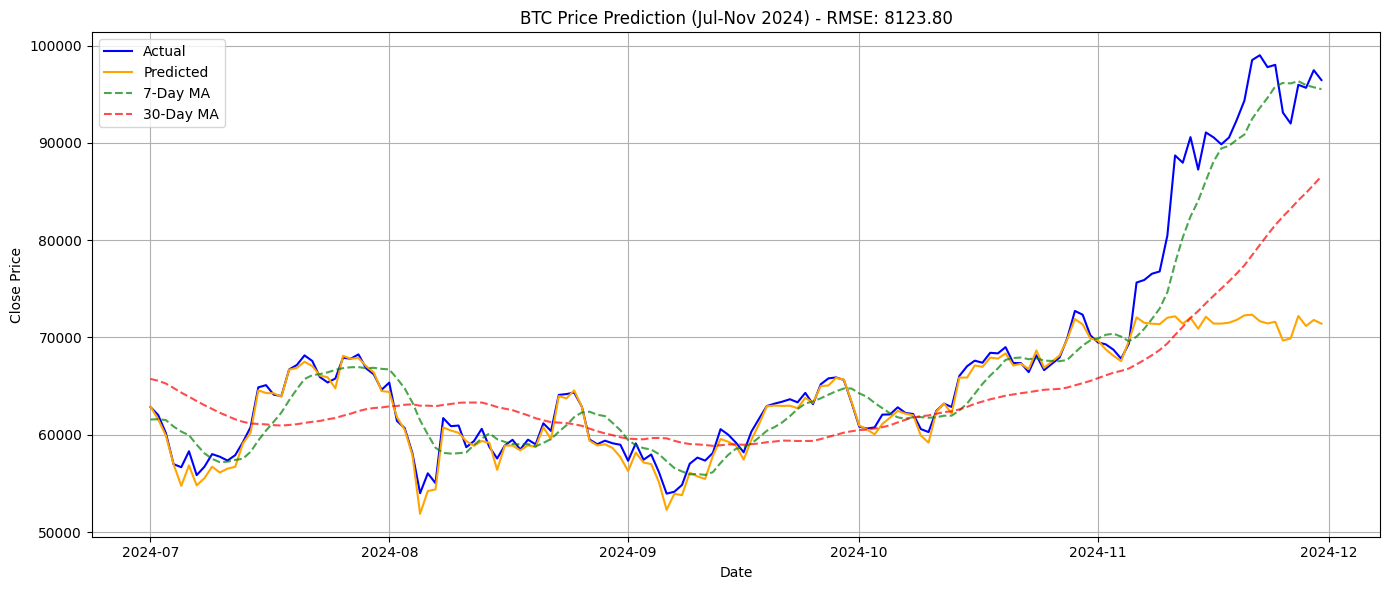

✅ Filtered RMSE (Jul–Nov 2024): 8123.80
📉 Filtered MAPE: 4.07%


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- Carrega e prepara o dataset ---
# Assume that df is already loaded with your data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['fng_value'] = pd.to_numeric(df['fng_value'], errors='coerce')
label_encoder = LabelEncoder()
df['fng_class_encoded'] = label_encoder.fit_transform(df['fng_classification'])

# --- Adiciona features temporais ---
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_ma3'] = df['Close'].rolling(window=3).mean()
df['Close_std3'] = df['Close'].rolling(window=3).std()
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['weekday'] = df['Date'].dt.weekday

# --- Adiciona features de momentum e volatilidade ---
df['price_change'] = df['Close'].pct_change()
df['price_change_3d'] = df['Close'].pct_change(periods=3)
df['price_change_7d'] = df['Close'].pct_change(periods=7)
df['price_change_14d'] = df['Close'].pct_change(periods=14)

# Volatility indicators
df['volatility_3d'] = df['price_change'].rolling(window=3).std()
df['volatility_7d'] = df['price_change'].rolling(window=7).std()
df['volatility_14d'] = df['price_change'].rolling(window=14).std()

# Add moving averages
df['Close_ma7'] = df['Close'].rolling(window=7).mean()
df['Close_ma14'] = df['Close'].rolling(window=14).mean()
df['Close_ma30'] = df['Close'].rolling(window=30).mean()

# Add FNG momentum
df['fng_change'] = df['fng_value'].diff()
df['fng_ma7'] = df['fng_value'].rolling(window=7).mean()
df['fng_ma14'] = df['fng_value'].rolling(window=14).mean()

# Add technical indicators
# RSI (Relative Strength Index)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi_14'] = calculate_rsi(df['Close'], 14)

# MACD (Moving Average Convergence Divergence)
df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

# Bollinger Bands
df['bb_middle'] = df['Close'].rolling(window=20).mean()
df['bb_std'] = df['Close'].rolling(window=20).std()
df['bb_upper'] = df['bb_middle'] + 2 * df['bb_std']
df['bb_lower'] = df['bb_middle'] - 2 * df['bb_std']
df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']

# Ratio between current price and moving averages
df['price_to_ma7'] = df['Close'] / df['Close_ma7']
df['price_to_ma14'] = df['Close'] / df['Close_ma14']
df['price_to_ma30'] = df['Close'] / df['Close_ma30']

# Distance from all-time high (to detect market regime)
df['all_time_high'] = df['Close'].cummax()
df['distance_from_ath'] = df['Close'] / df['all_time_high']

# Momentum features - rate of change
df['roc_5'] = df['Close'].pct_change(5) * 100
df['roc_10'] = df['Close'].pct_change(10) * 100

# Add log-transformed price (can help with non-linearity)
df['log_price'] = np.log(df['Close'])
df['log_volume'] = np.log(df['Volume'] + 1)  # Adding 1 to avoid log(0)

# Remove valores nulos causados por shift e rolling
df.dropna(inplace=True)

# --- Features e Target ---
features = [
    'Open', 'High', 'Low', 'Volume', 'log_volume', 
    'fng_value', 'fng_class_encoded',
    'Close_lag1', 'Close_lag2', 'Close_lag3', 'Close_ma3', 'Close_std3',
    'day', 'month', 'weekday',
    'price_change', 'price_change_3d', 'price_change_7d', 'price_change_14d',
    'volatility_3d', 'volatility_7d', 'volatility_14d',
    'Close_ma7', 'Close_ma14', 'Close_ma30',
    'fng_change', 'fng_ma7', 'fng_ma14',
    'rsi_14', 'macd', 'macd_signal', 'macd_hist',
    'bb_width', 'price_to_ma7', 'price_to_ma14', 'price_to_ma30',
    'distance_from_ath', 'roc_5', 'roc_10'
]
target = 'Close'

X = df[features]
y = df[target]

# --- Split (sem shuffle, respeitando o30 X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# --- XGBoost Model ---
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42
)

# --- Adiciona pesos para dar mais importância aos dados recentes ---
# Generate weights that increase linearly with time
train_weights = np.linspace(0.5, 1.0, len(y_train))

# --- Fit the model on training data with sample weights ---
model.fit(
    X_train,
    y_train,
    sample_weight=train_weights
)


# --- Define date range for focused evaluation ---
start_date = "2024-07-01"
end_date = "2024-11-30"

# Filter test set by date range
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df_filtered = df.loc[mask].copy()

# Predicted values within the date range
# Match indices from original prediction
test_index_filtered = df_filtered.index.intersection(y_test.index)
y_test_filtered = y_test.loc[test_index_filtered]
y_pred_filtered = pd.Series(y_pred, index=y_test.index).loc[test_index_filtered]

# Recalculate RMSE and MAPE for this range
rmse_filtered = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
mape_filtered = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100

# --- Plot for the selected window ---
plt.figure(figsize=(14, 6))
plt.plot(df_filtered['Date'], y_test_filtered, label='Actual', color='blue')
plt.plot(df_filtered['Date'], y_pred_filtered, label='Predicted', color='orange')
plt.plot(df_filtered['Date'], df_filtered['Close_ma7'], 
         label='7-Day MA', color='green', linestyle='--', alpha=0.7)
plt.plot(df_filtered['Date'], df_filtered['Close_ma30'], 
         label='30-Day MA', color='red', linestyle='--', alpha=0.7)

plt.title(f"BTC Price Prediction (Jul-Nov 2024) - RMSE: {rmse_filtered:.2f}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("btc_prediction_Jul_to_Nov_2024.png")
plt.show()

print(f"✅ Filtered RMSE (Jul–Nov 2024): {rmse_filtered:.2f}")
print(f"📉 Filtered MAPE: {mape_filtered:.2f}%")


In [18]:
# Verificar a variância nos dados de teste (X_test)
import pandas as pd

# Convertemos X_test para DataFrame se não for ainda
X_test_df = pd.DataFrame(X_test, columns=features)

# Calculamos o desvio padrão para ver a variabilidade
variancia_teste = X_test_df.describe().T[['mean', 'std', 'min', 'max']]

print("📊 Estatísticas do conjunto de teste (últimos dados usados):")
display(variancia_teste)

# Ver últimas 5 linhas para ver se os inputs estão mesmo repetitivos
print("\n🔍 Últimas 5 linhas do X_test (inputs que geraram a linha reta):")
display(X_test_df.tail())


📊 Estatísticas do conjunto de teste (últimos dados usados):


,mean,std,min,max
Open,7.813767e+04,1.684791e+04,5.394909e+04,1.061473e+05
High,7.968647e+04,1.718096e+04,5.483814e+04,1.091149e+05
Low,7.654461e+04,1.645608e+04,4.912124e+04,1.052917e+05
Volume,4.272400e+10,2.492297e+10,9.858199e+09,1.492189e+11
log_volume,2.433064e+01,5.395522e-01,2.301157e+01,2.572868e+01
fng_value,5.547387e+01,2.012110e+01,1.000000e+01,9.400000e+01
fng_class_encoded,2.372822e+00,1.123662e+00,0.000000e+00,4.000000e+00
Close_lag1,7.813558e+04,1.684775e+04,5.394875e+04,1.061463e+05
Close_lag2,7.806739e+04,1.685175e+04,5.394875e+04,1.061463e+05
Close_lag3,7.800482e+04,1.685005e+04,5.394875e+04,1.061463e+05



🔍 Últimas 5 linhas do X_test (inputs que geraram a linha reta):


,Open,High,Low,Volume,log_volume,fng_value,fng_class_encoded,Close_lag1,Close_lag2,Close_lag3,...,macd,macd_signal,macd_hist,bb_width,price_to_ma7,price_to_ma14,price_to_ma30,distance_from_ath,roc_5,roc_10
1455,83831.898438,86094.781250,83794.914062,12594615537,23.256535,30,2,83832.484375,84043.242188,84167.195312,...,-1615.666902,-2273.961744,658.294842,0.139264,1.017972,1.030749,0.999508,0.810715,4.032804,6.152553
1456,86070.929688,88758.726562,85541.195312,34582604933,24.266617,45,2,86054.375000,83832.484375,84043.242188,...,-1259.490095,-2071.067414,811.577319,0.139906,1.029107,1.040073,1.019871,0.824324,0.742264,4.203704
1457,87512.820312,88542.398438,86346.078125,30005840049,24.124658,46,2,87498.914062,86054.375000,83832.484375,...,-968.251702,-1850.504272,882.252570,0.127323,1.020636,1.035696,1.023052,0.824068,3.926123,3.709365
1458,87460.234375,88292.156250,85861.453125,26704046038,24.008081,47,4,87471.703125,87498.914062,86054.375000,...,-774.574790,-1635.318375,860.743585,0.115138,1.013896,1.026178,1.018169,0.818690,3.400203,5.232758
1459,86896.257812,87786.726562,85837.937500,24413471941,23.918401,40,2,86900.882812,87471.703125,87498.914062,...,-591.972012,-1426.649103,834.677090,0.116329,1.012042,1.024162,1.022028,0.821292,3.989643,3.688836
